# Notebook to process data to see census comparison for each adjustments

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from PopSynthesis.Methods.connect_HH_PP.paras_dir import output_dir, data_dir
from PopSynthesis.Methods.connect_HH_PP.scripts.utils import convert_full_to_marg_count

In [2]:
font = {'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)

geo_lev = "POA"

In [3]:
# Import adjustments (5 of them, but I think will show 4 only)
hh_ad0 = pd.read_csv(os.path.join(output_dir, "new_test", "hh_no_adjustments.csv")) # no adjustment
hh_ad1 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_hhsize.csv")) # hhsize
hh_ad2 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_totalvehs.csv")) # totavehs
hh_ad3 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_hhinc.csv")) # hhinc
hh_ad4 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_dwelltype.csv")) # dwelltype
hh_ad5 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_owndwell.csv")) # owndwell

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_2852\1395760565.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  hh_ad1 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_hhsize.csv")) # hhsize
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_2852\1395760565.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  hh_ad2 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_totalvehs.csv")) # totavehs
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_2852\1395760565.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  hh_ad3 = pd.read_csv(os.path.join(output_dir, "adjust", "final", "saving_hh_hhinc.csv")) # hhinc
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_2852\1395760565.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  hh_ad4 = pd.read

In [4]:
ls_hh_ordered = [hh_ad0, hh_ad1, hh_ad2, hh_ad3, hh_ad4, hh_ad5]
ls_hh_ordered = [x.astype(str) for x in ls_hh_ordered]

In [5]:
marg_hh = pd.read_csv(os.path.join(data_dir,f"hh_marginals_ipu.csv"), header=[0,1])

hold = marg_hh.columns[marg_hh.columns.get_level_values(0)=="zone_id"]
marg_hh = marg_hh.set_index(hold[0])
marg_hh = marg_hh.drop(columns=list(marg_hh.columns[marg_hh.columns.get_level_values(0).isin(["sample_geog", "zone_id"])]))
marg_hh.index.name = geo_lev

In [6]:
ls_zones = list(marg_hh.index)
ls_atts = ["hhsize", "totalvehs", "hhinc", "dwelltype", "owndwell"]

In [7]:
# Polynomial Regression
def r_squared(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

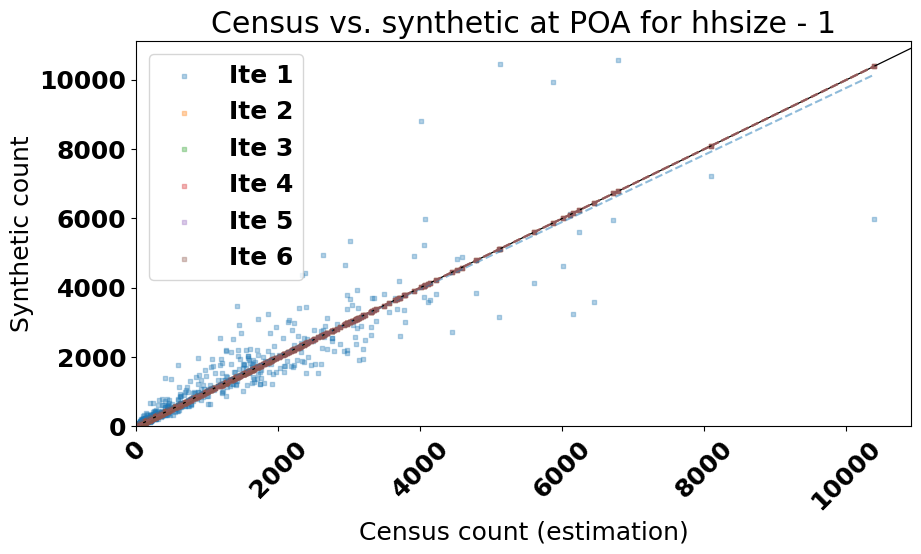

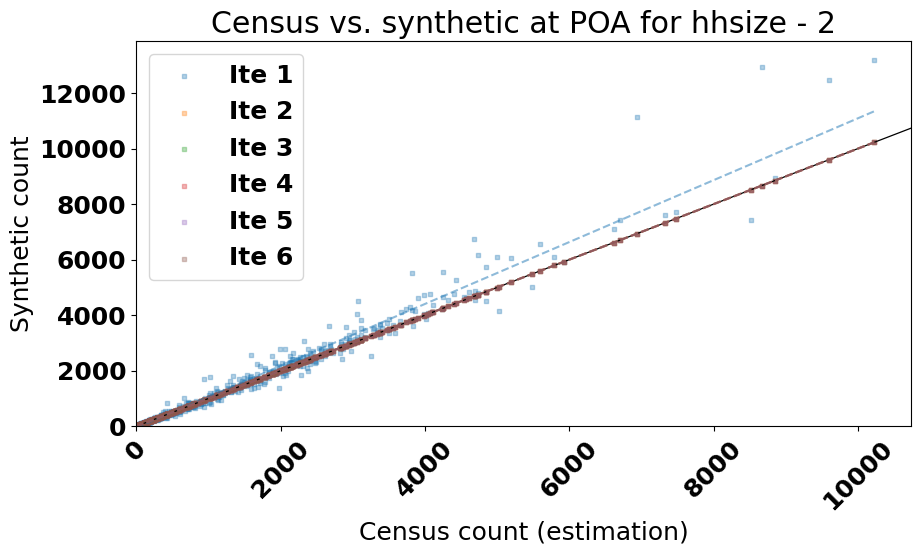

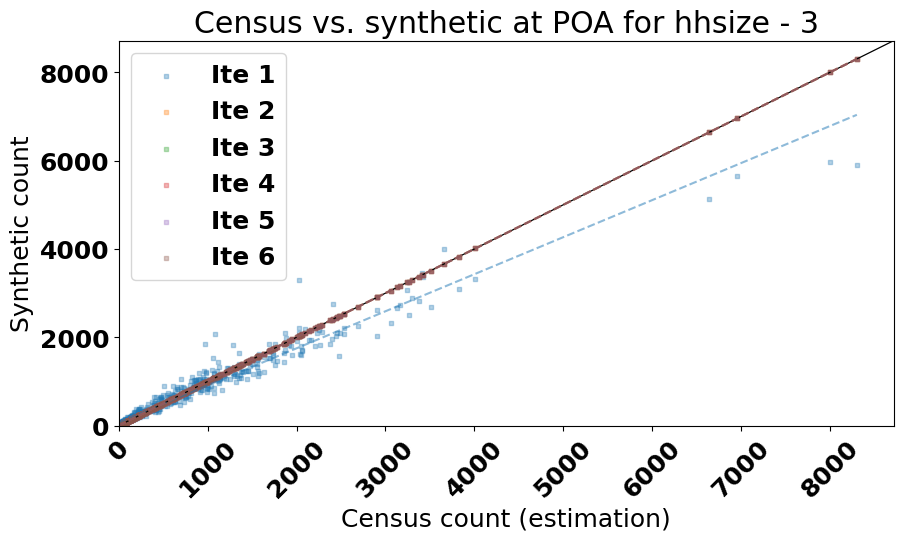

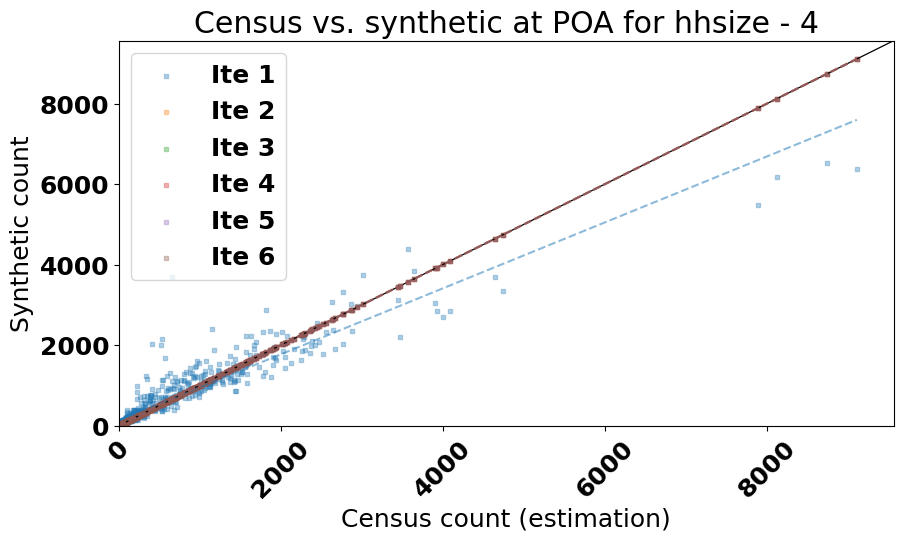

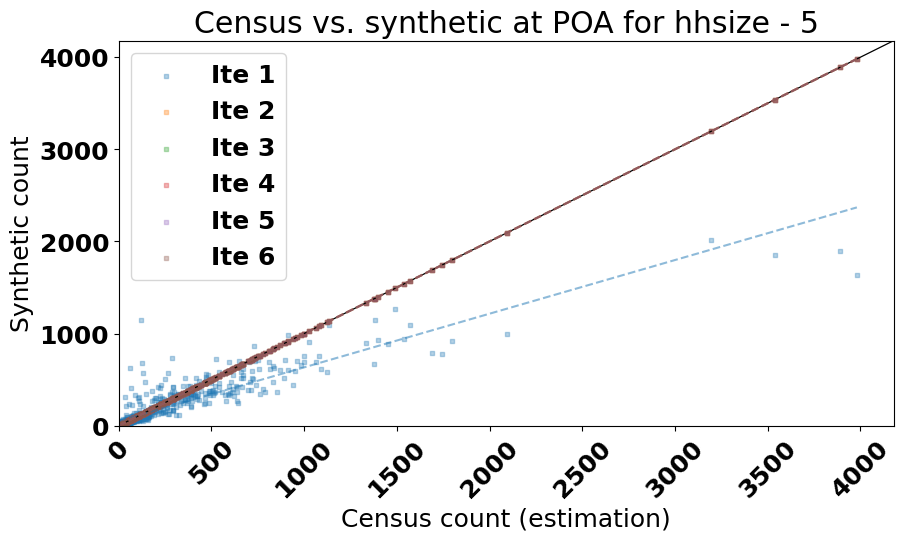

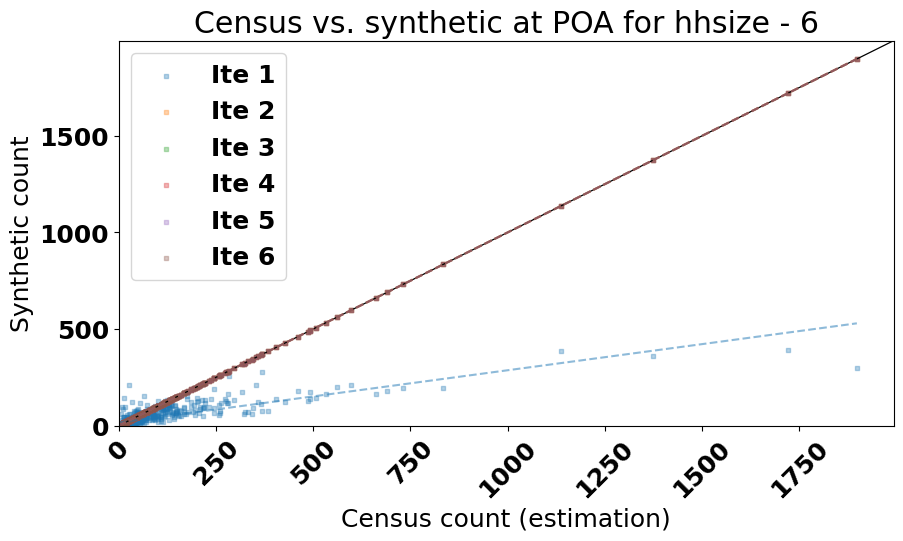

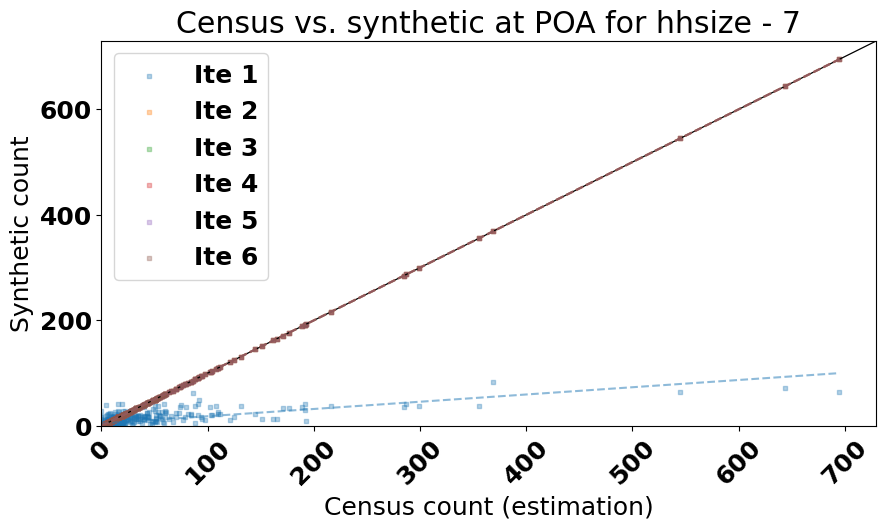

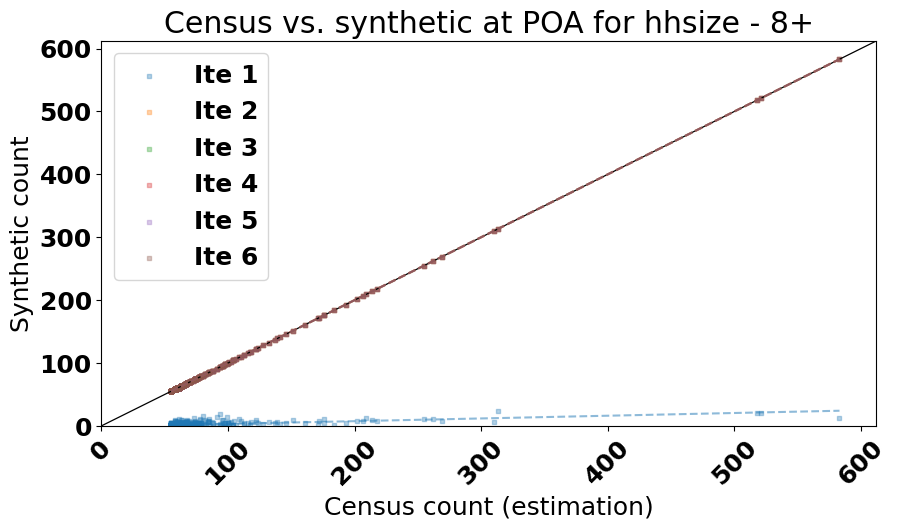

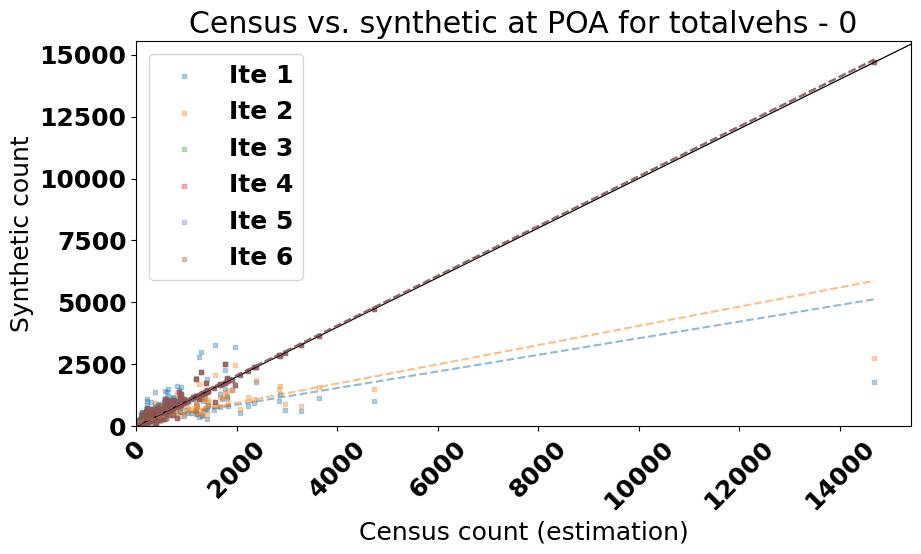

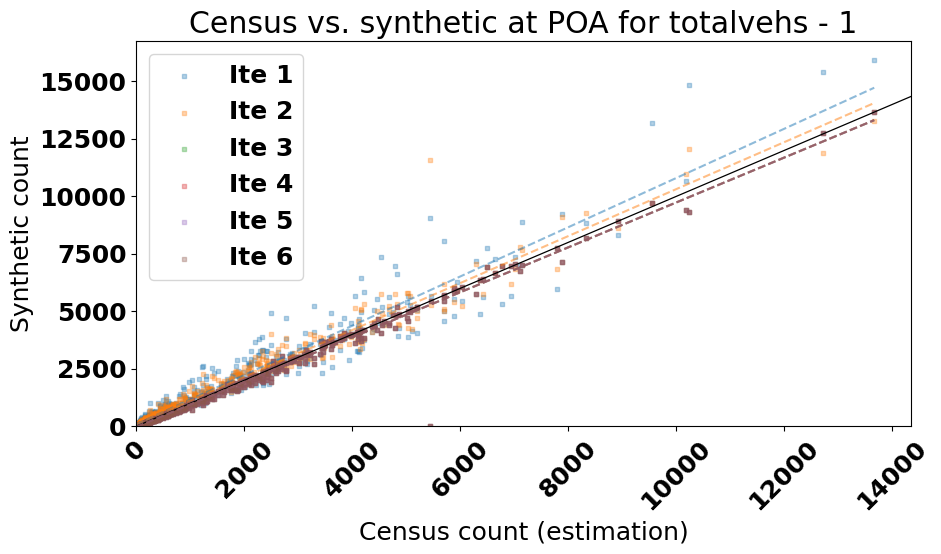

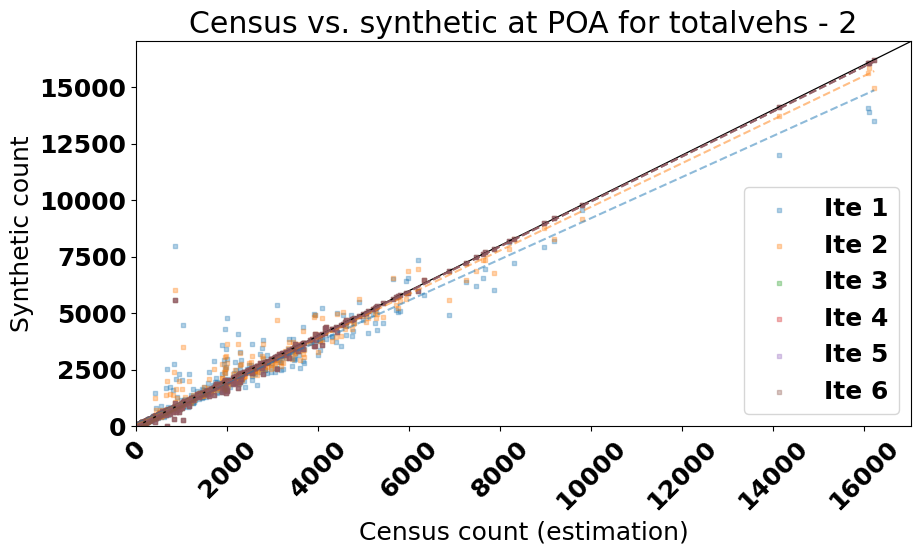

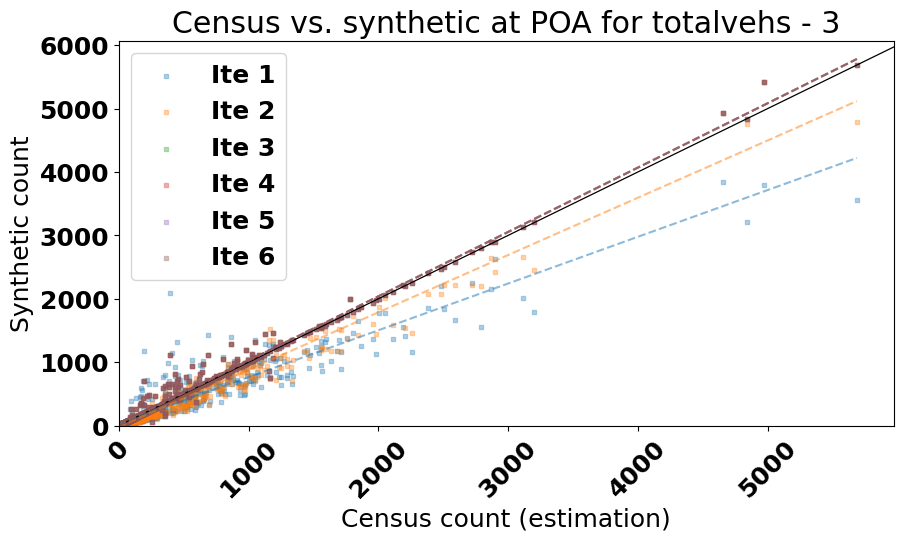

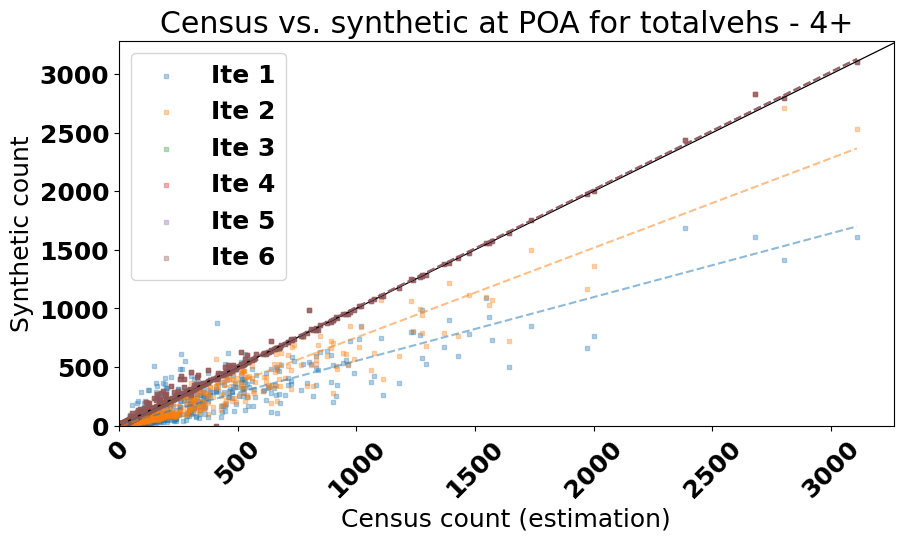

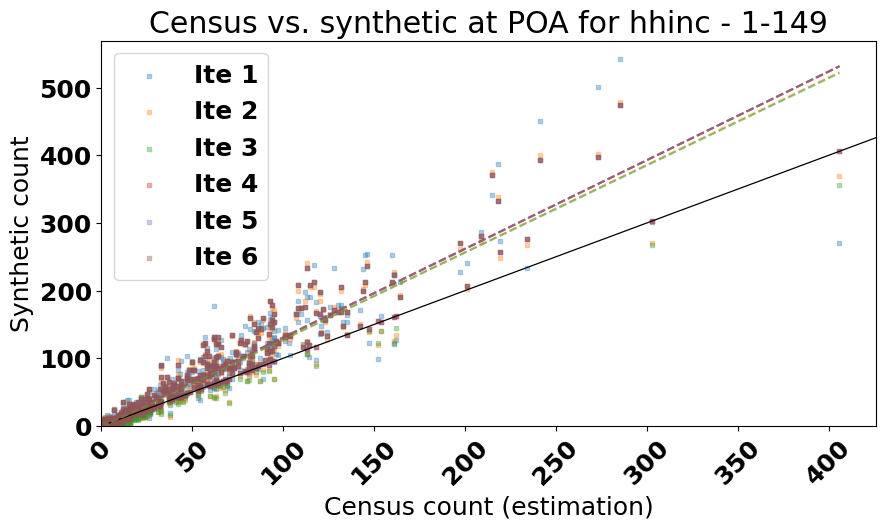

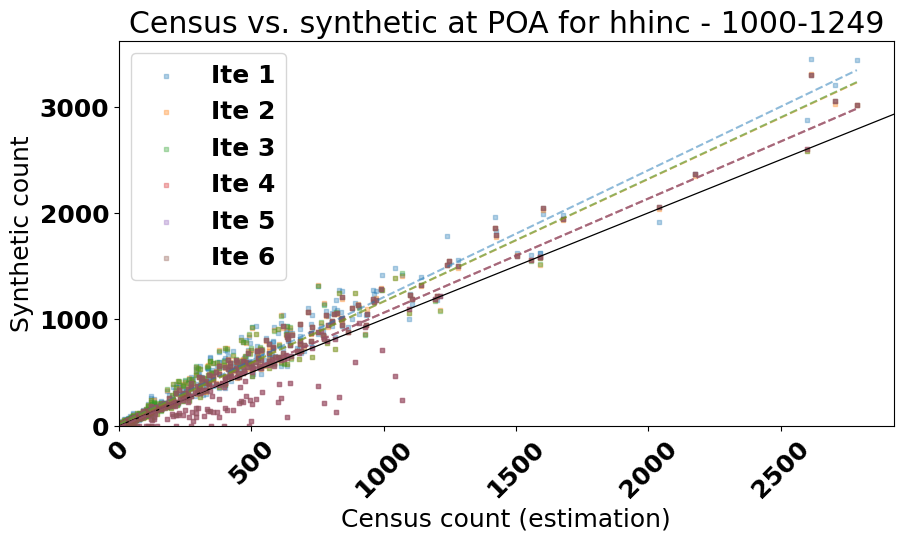

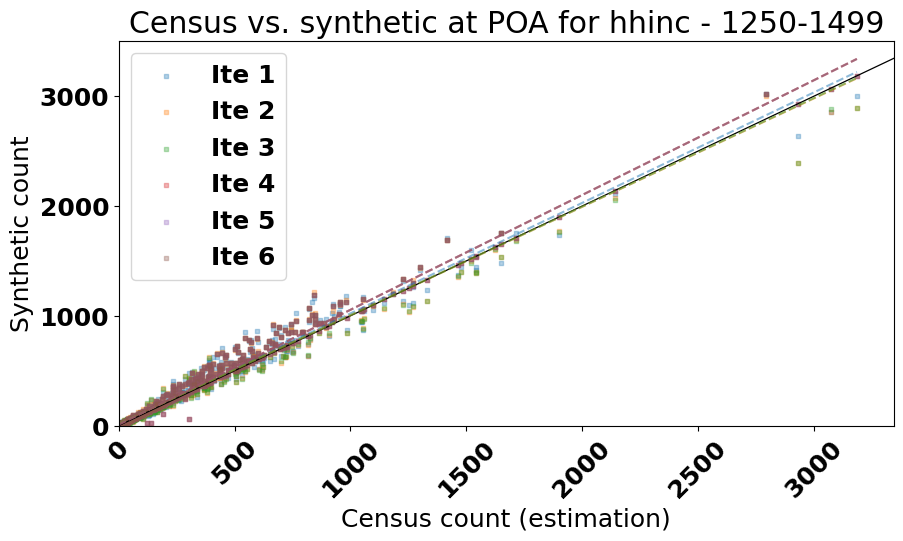

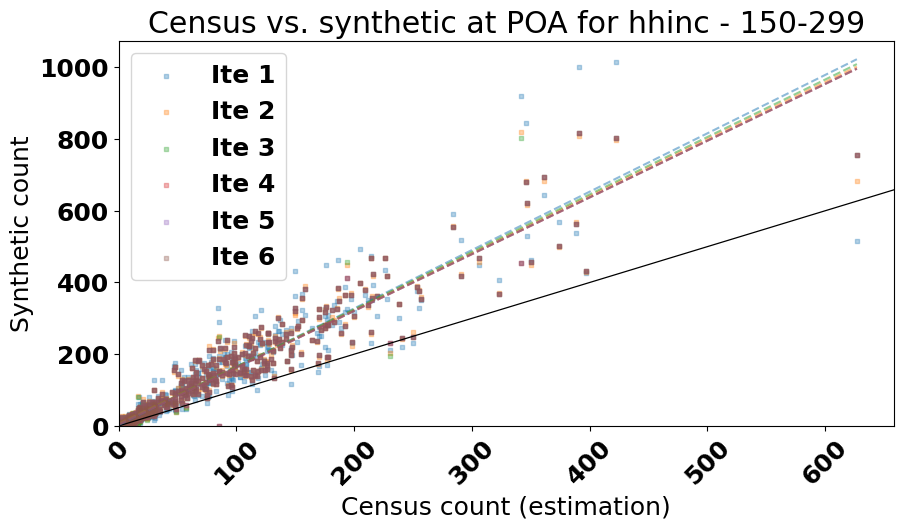

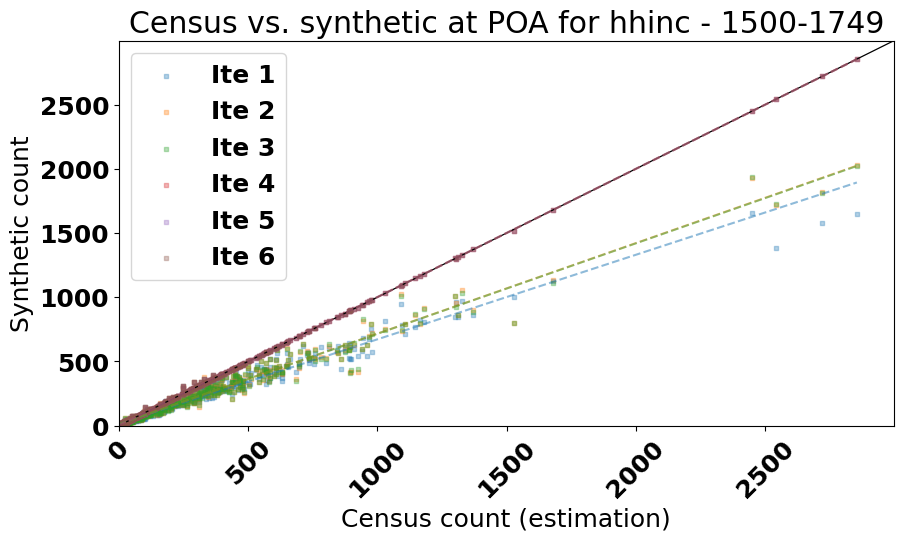

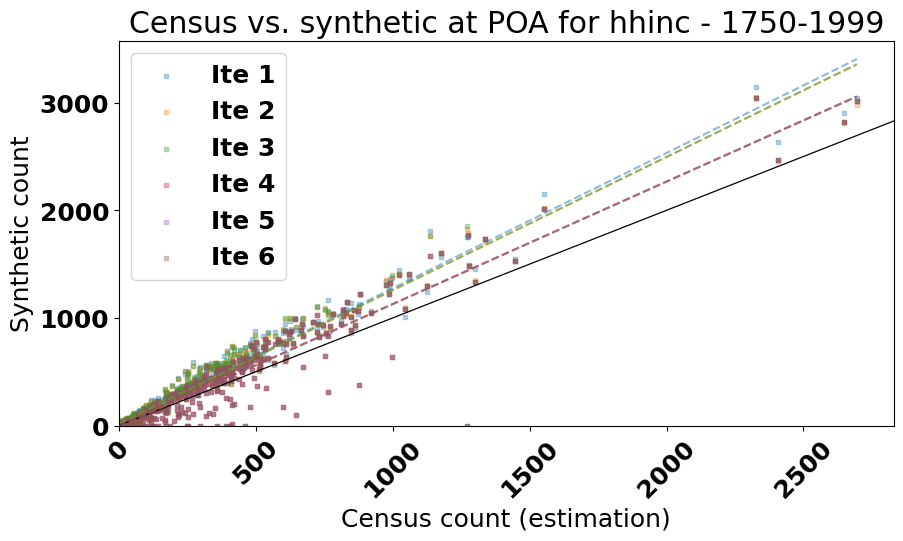

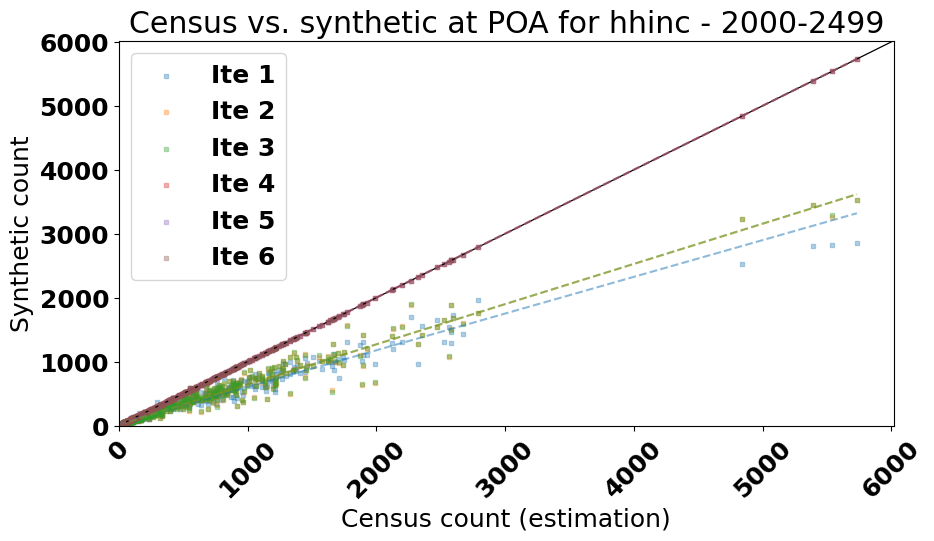

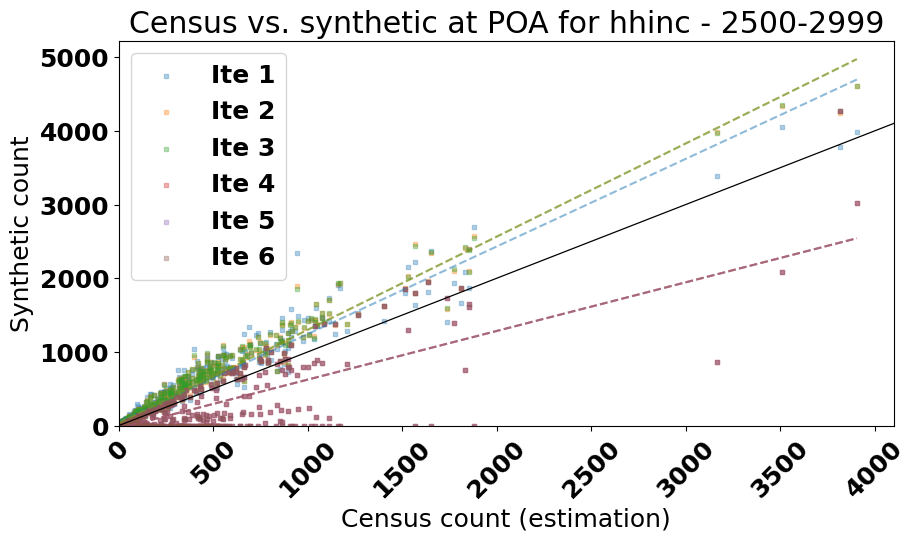

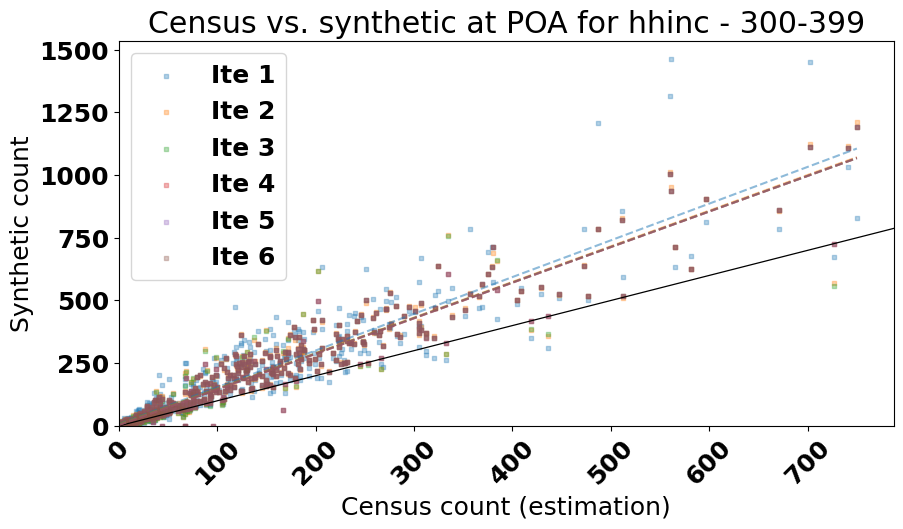

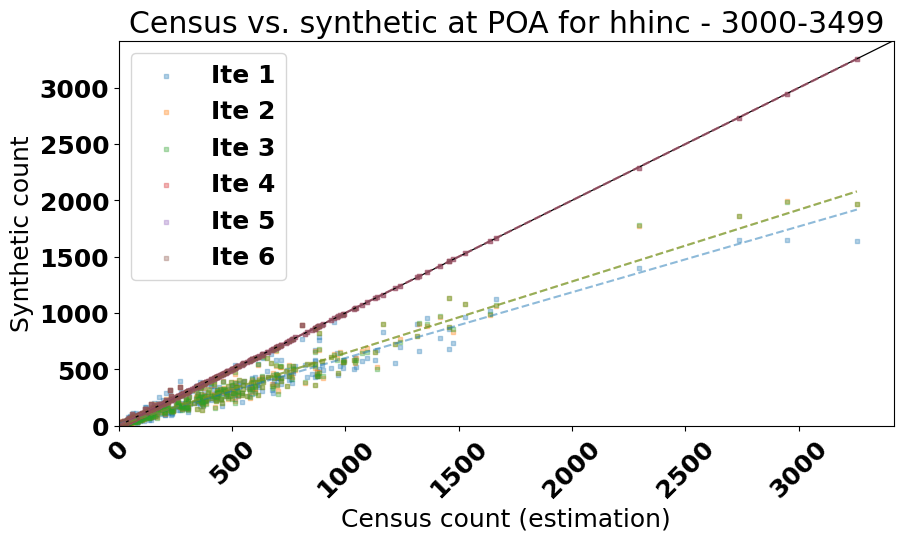

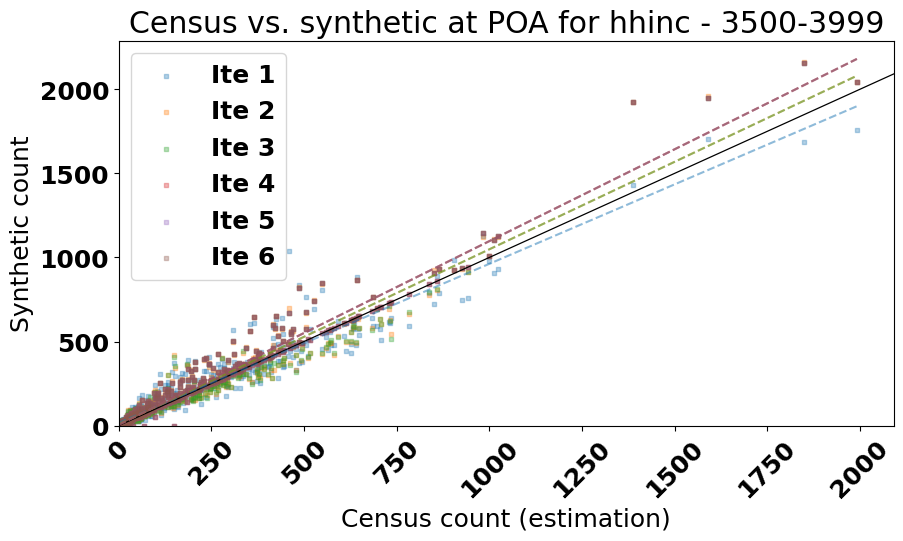

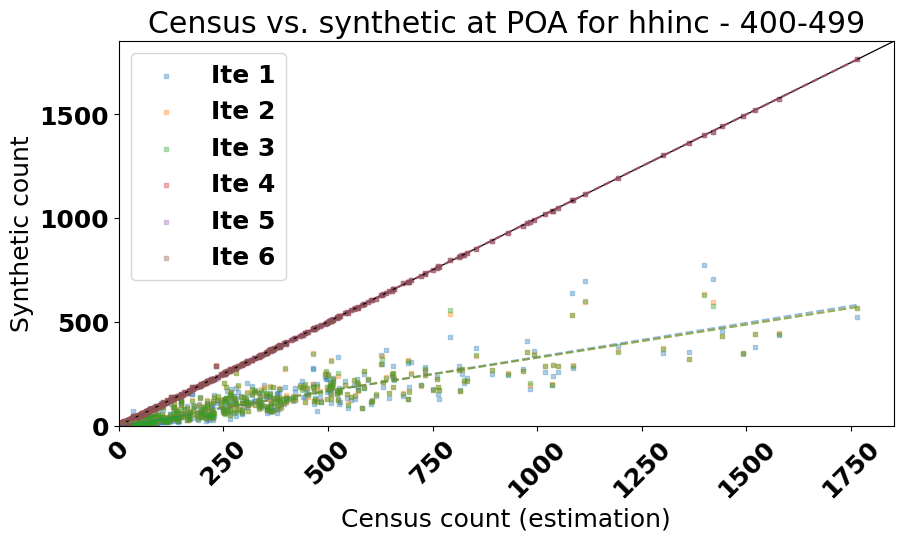

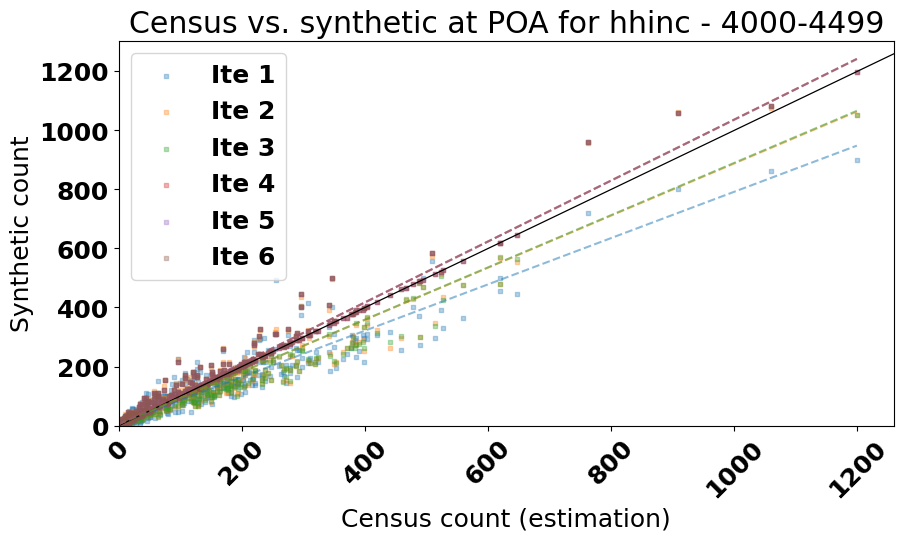

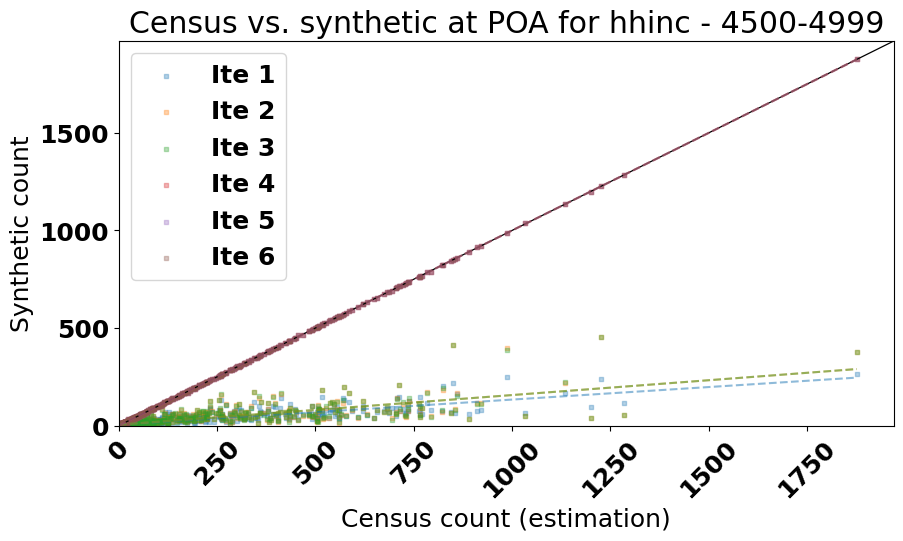

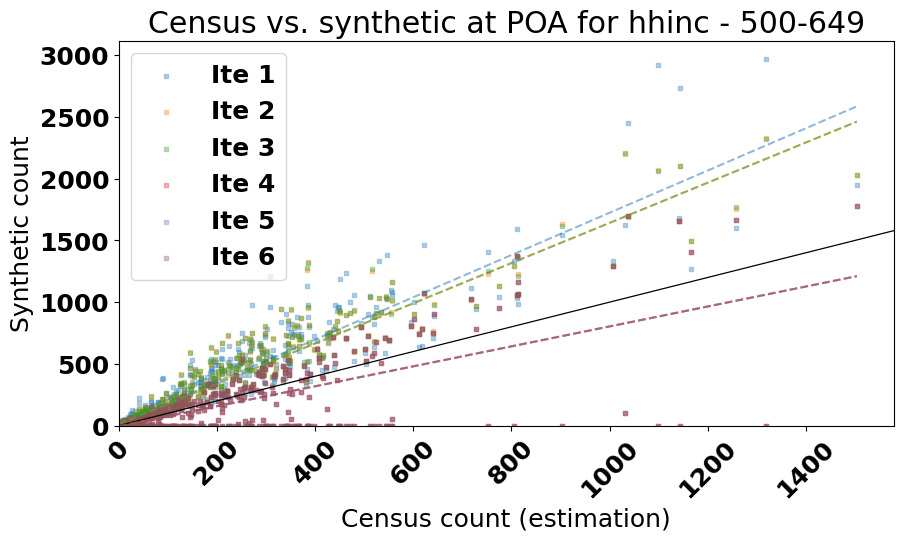

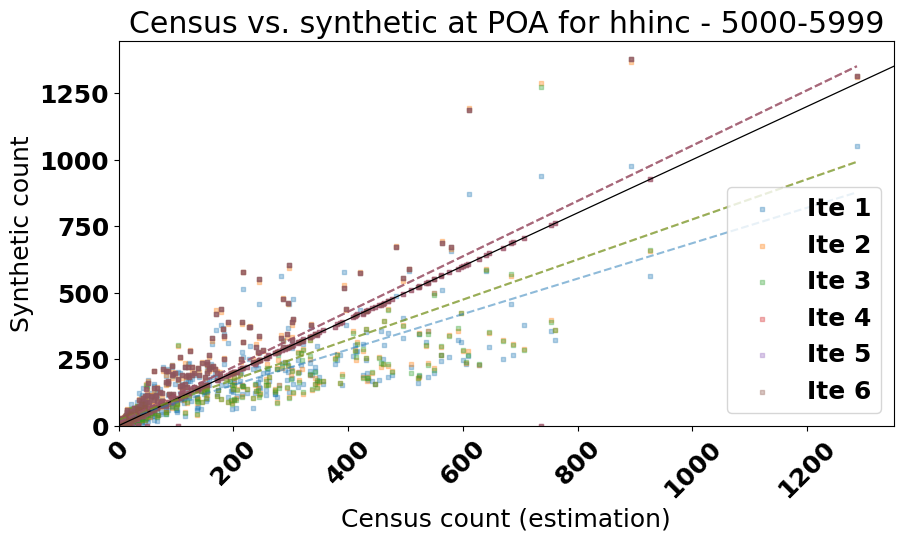

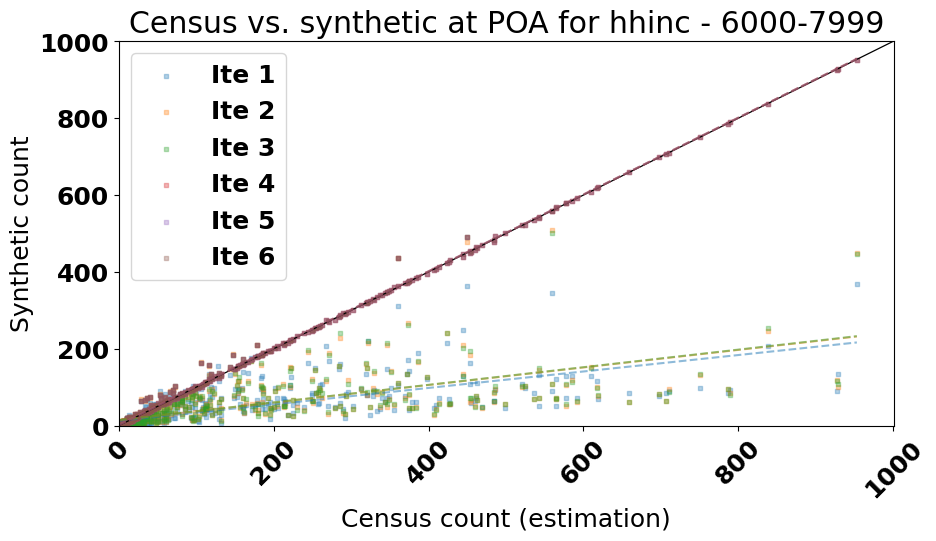

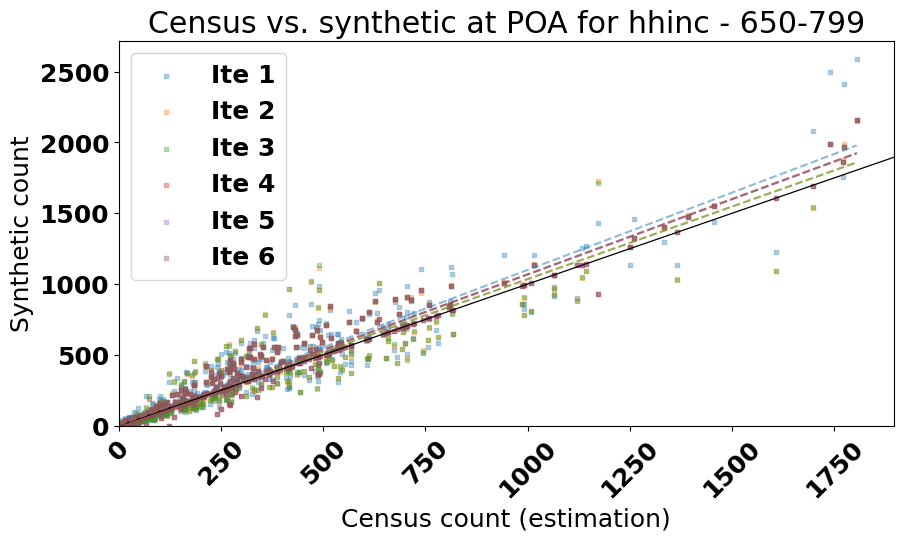

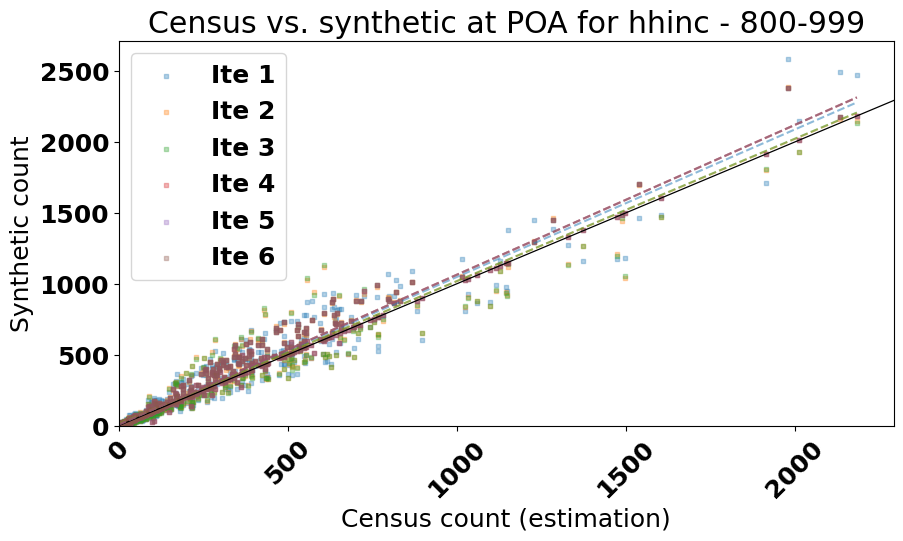

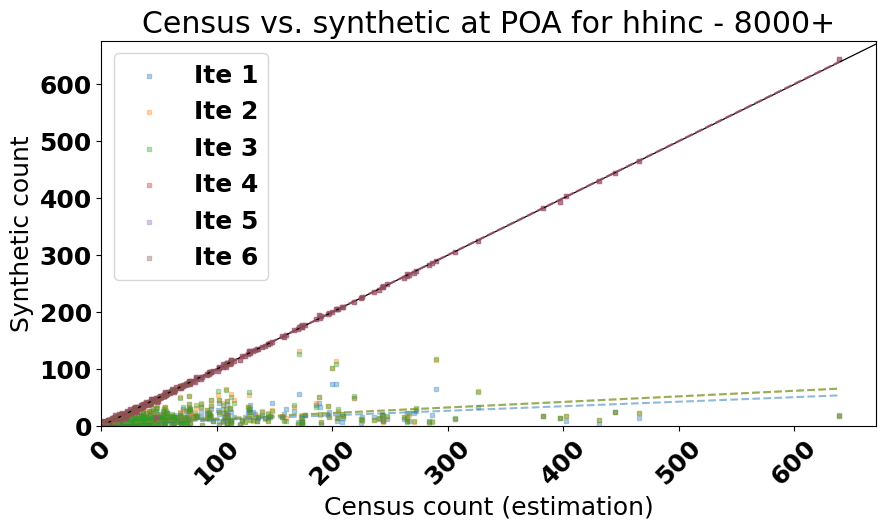

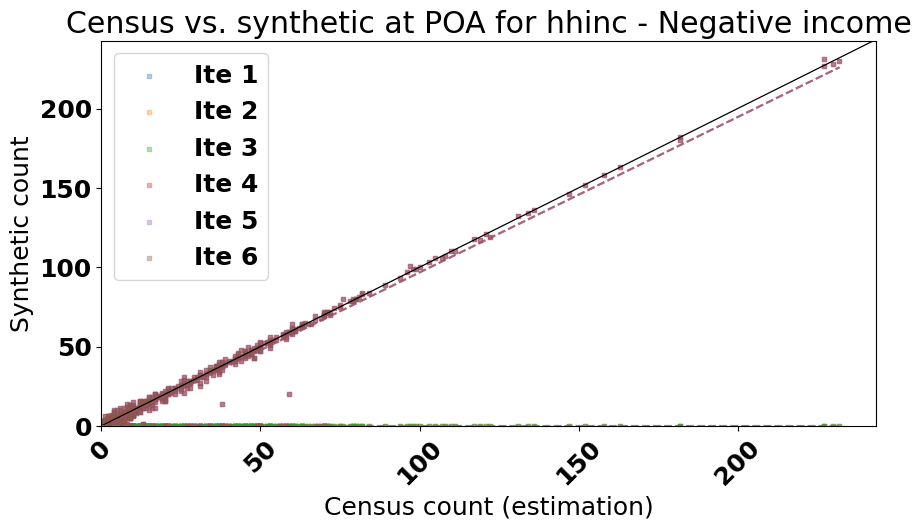

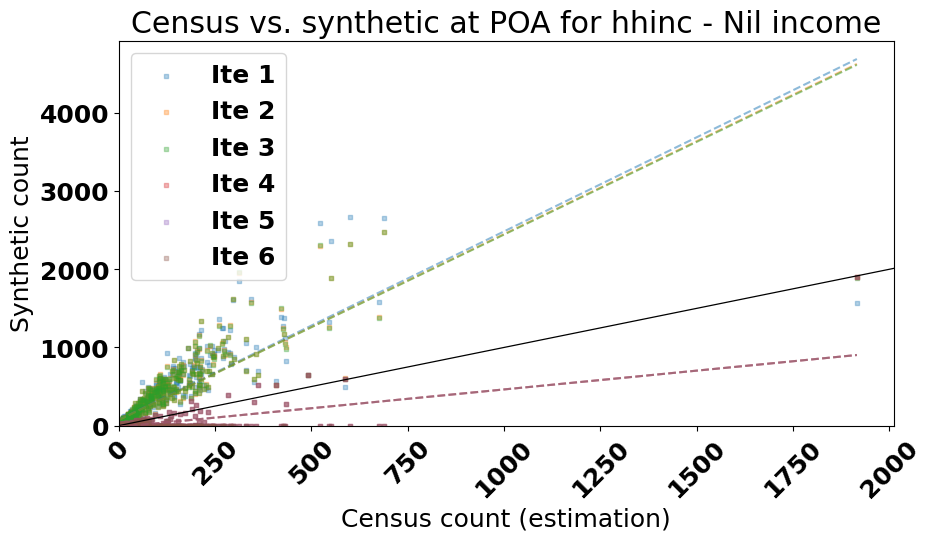

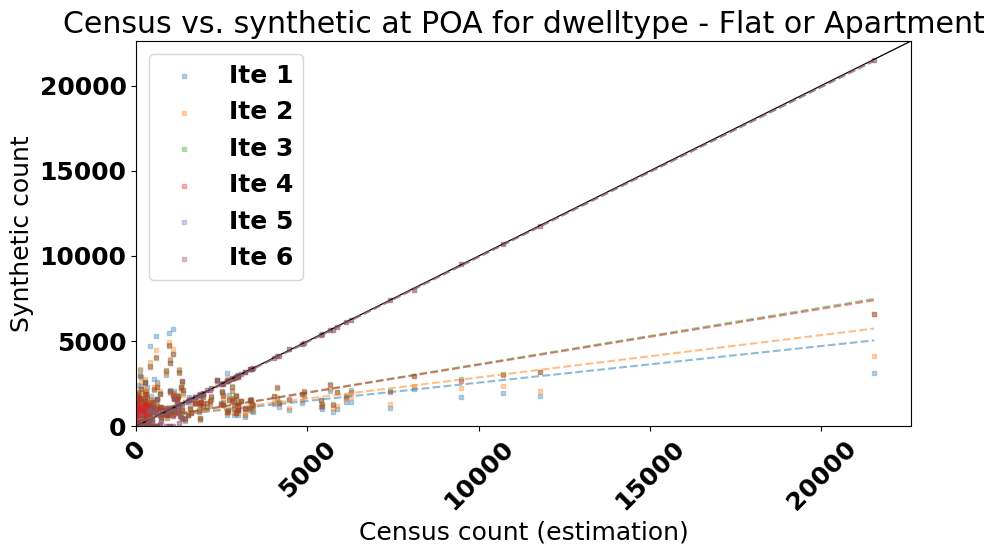

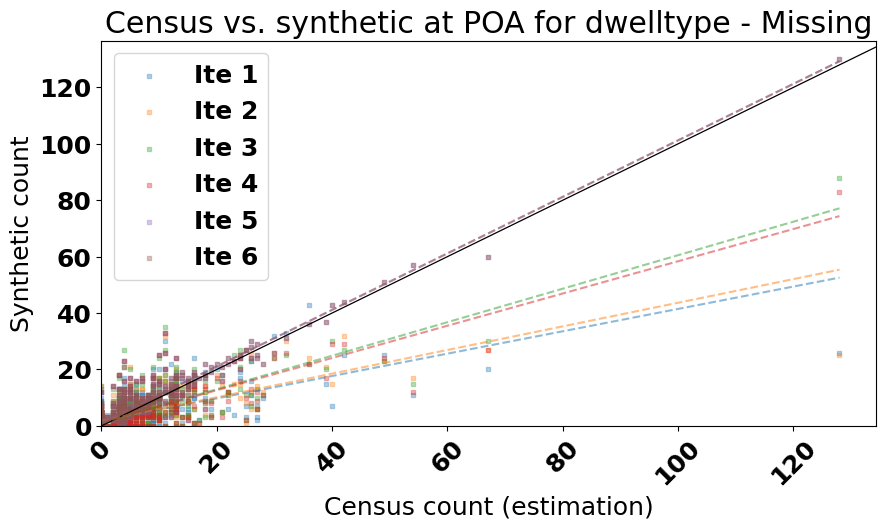

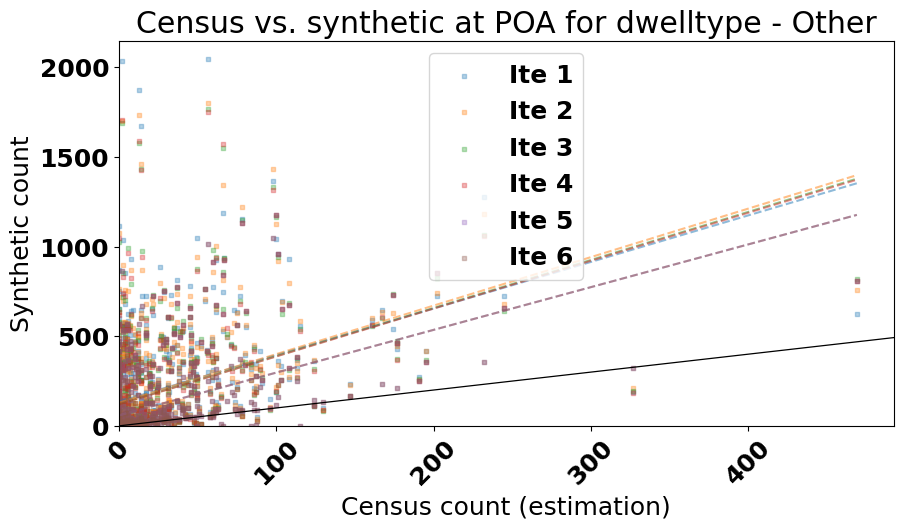

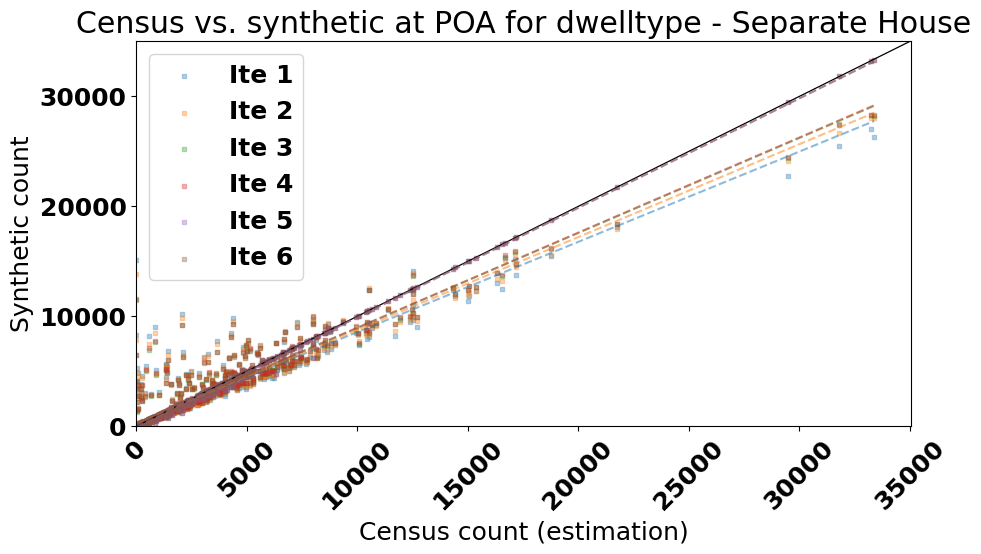

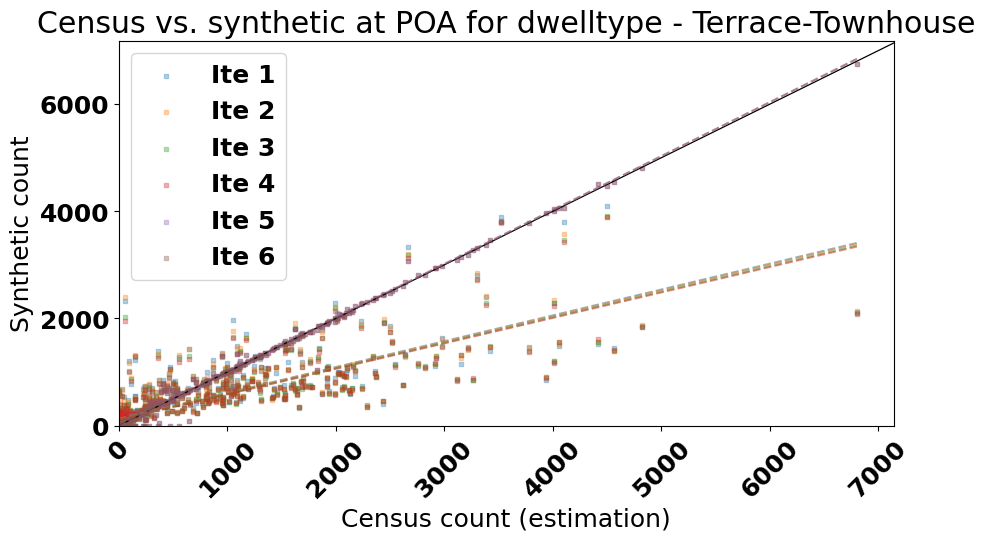

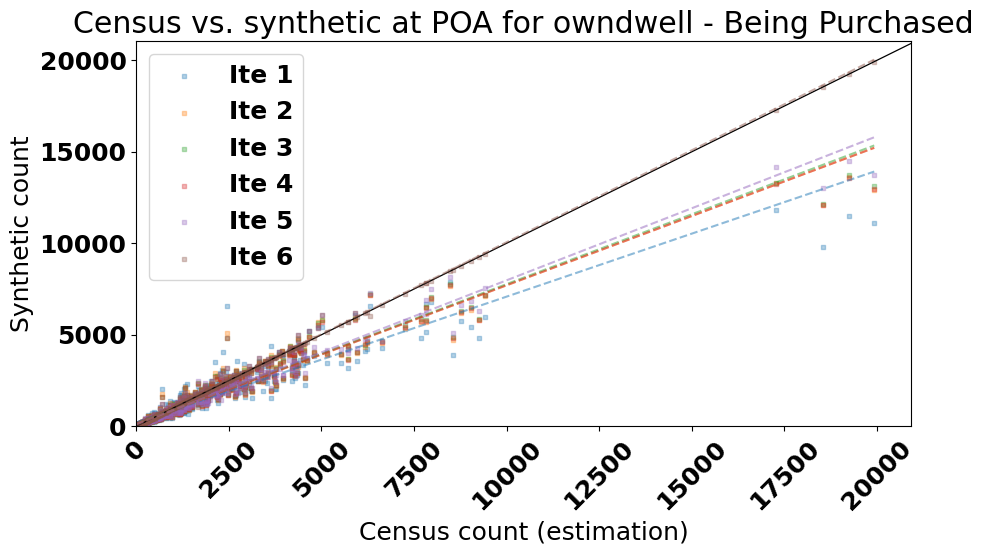

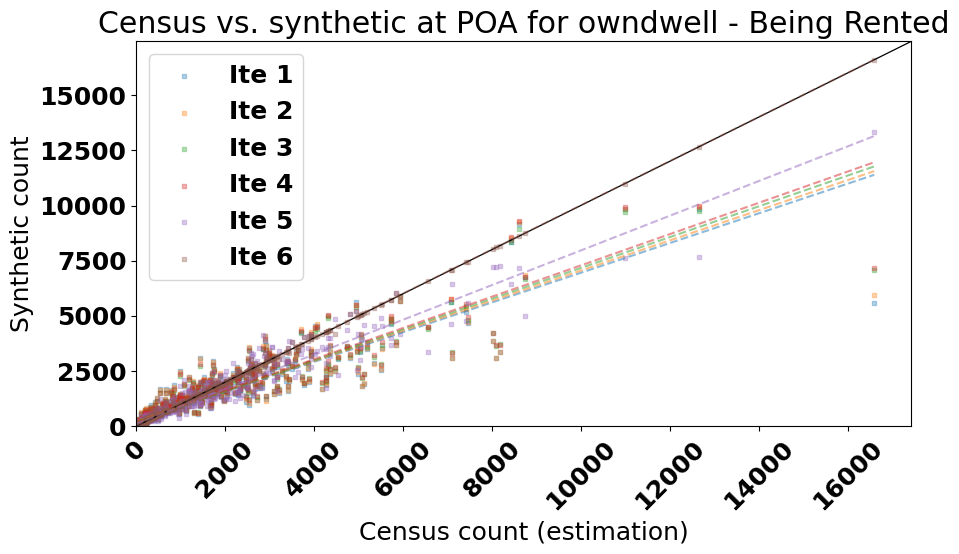

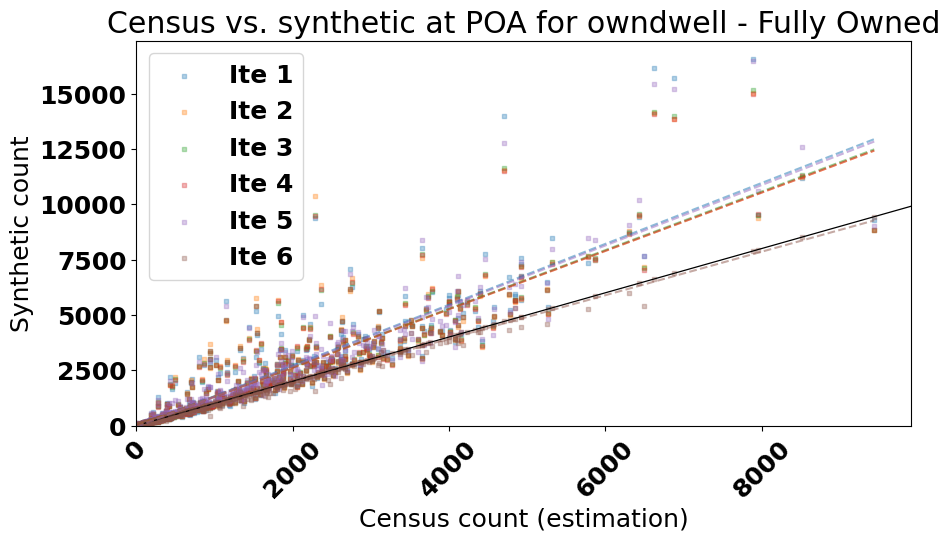

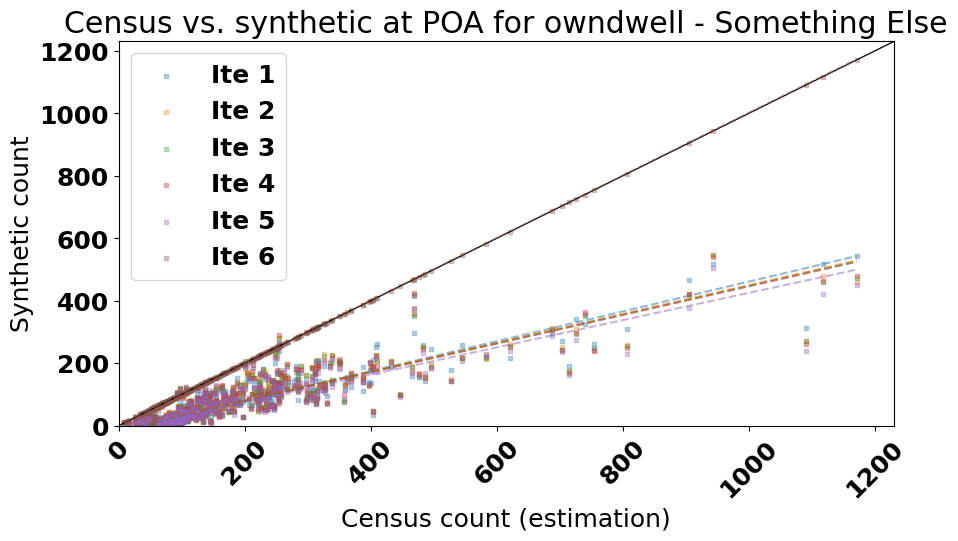

In [8]:
for chosen_att in ls_atts:
    ls_syn = [x.groupby(chosen_att)[geo_lev].value_counts() for x in ls_hh_ordered]

    att_df = marg_hh[marg_hh.columns[marg_hh.columns.get_level_values(0)==chosen_att]]
    att_df.index = att_df.index.astype(str)

    to_plot = {}
    for val in att_df.columns.get_level_values(1).unique():
        to_plot[val] = [[], [], [], [], [], [], []]
        for poa in att_df.index:
            to_plot[val][0].append(att_df.loc[poa][(chosen_att ,val)])
            for i, syn in enumerate(ls_syn):
                if (val, poa) in syn.index:
                    to_plot[val][i+1].append(syn[(val, poa)])
                else:
                    to_plot[val][i+1].append(0)

    for val in att_df.columns.get_level_values(1):
        x = list(to_plot[val][0])

        fig = plt.figure(figsize = (10, 5))
        ax1 = fig.add_subplot(111)
        ax1.axline((0, 0), slope=1, c="black", linewidth=0.9)

        for i, syn in enumerate(ls_syn):
            y = list(to_plot[val][i+1])
            ax1.scatter(x, y, s=10, marker="s", label=f'Ite {i+1}', alpha=0.33)
            y_best_fit= np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
            ax1.plot(np.unique(x), y_best_fit, alpha=0.5, linestyle="--")

        plt.xlabel(f"Census count (estimation)")
        plt.ylabel("Synthetic count")
        val = val.replace("/", "-")
        plt.title(f"Census vs. synthetic at {geo_lev} for {chosen_att} - {val}")
        ax1.set_xlim(left=0)
        ax1.set_ylim(bottom=0)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        # plt.savefig(f"./compa/{chosen_att}_{val}_ites_adjust_compa.png")

In [9]:
def wrapper_produce_all_results(ls_syn_pop_name, benchmark_marg, geo_lev, geo_file, ls_sub_zones=None, to_plot=False, all_name=""):
    ls_atts = list(benchmark_marg.columns.get_level_values(0).unique())
    n_zones = len(marg_hh.index)
    benchmark_marg.index = benchmark_marg.index.astype(str)

    ls_series_zones = []
    ls_series_atts = []
    ls_series_states = []
    ls_names = []
    for syn_pop, name in ls_syn_pop_name:
        ls_names.append(name)
        converted_m = convert_full_to_marg_count(syn_pop, geo_lev, [x for x in syn_pop if x not in ls_atts])
        diff_se_m = (converted_m - benchmark_marg)**2\
        # Process for zones
        zones_rmse = diff_se_m.mean(axis=1).apply(lambda x: np.sqrt(x))
        zones_rmse.name = name
        ls_series_zones.append(zones_rmse)
        # Process for atts
        atts_rmse = pd.Series(name=name)
        for att in ls_atts:
            sub_diff = diff_se_m[diff_se_m.columns[diff_se_m.columns.get_level_values(0)==att]]
            # sub_diff.columns = sub_diff.columns.droplevel(0)
            sum_sub = sub_diff.mean(axis=1).apply(lambda x: np.sqrt(x))
            atts_rmse.loc[att] = sum_sub.mean()
        ls_series_atts.append(atts_rmse)
        # Process for states
        states_rmse = diff_se_m.sum() / n_zones
        states_rmse.name = name
        ls_series_states.append(states_rmse)
    fin_zones_df = pd.concat(ls_series_zones, axis=1)
    # Process for final score
    fin_rmse = fin_zones_df.mean()
    # Process to have geo info
    fin_zones_gdf = geo_file.merge(fin_zones_df, left_index=True, right_index=True)
    # Process for fin atts score
    fin_atts_df = pd.concat(ls_series_atts, axis=1)
    # Process for fin states score
    fin_states_df = pd.concat(ls_series_states, axis=1)
    if ls_sub_zones is None:
        fin_sub_zones = None
    else:
        fin_sub_zones = fin_zones_gdf[fin_zones_gdf.index.isin(ls_sub_zones)]
    
    if to_plot:
        for method in ls_names:
            ax_all = fin_zones_gdf.plot(column=method, legend=True, figsize=(10, 6), cmap="plasma")
            ax_all.set_title(f"All_VIC - {geo_lev} - {all_name}_RMSE_{method}")
            if fin_sub_zones is not None:
                ax_sub = fin_sub_zones.plot(column=method, legend=True, figsize=(10, 6), cmap="plasma")
                ax_sub.set_title(f"Metro_VIC - {all_name}_RMSE_{method}")
    return fin_zones_gdf, fin_sub_zones, fin_rmse, fin_atts_df, fin_states_df

In [10]:
import geopandas as gpd
poa_geo = gpd.read_file(os.path.join(data_dir,f"POA_2021_AUST_GDA2020_SHP.zip"), columns=["POA_CODE21"], engine="pyogrio")
poa_geo[geo_lev] = poa_geo["POA_CODE21"].astype(str)
poa_geo = poa_geo.set_index(geo_lev).drop(columns=["POA_CODE21"])

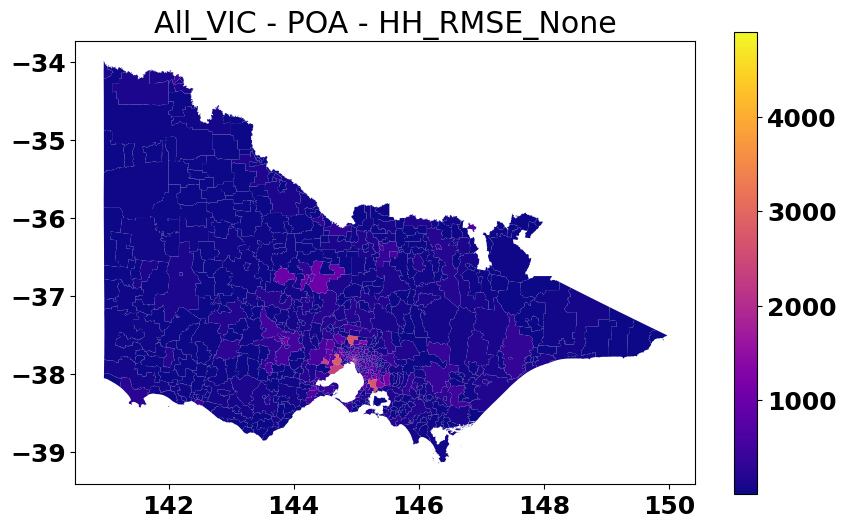

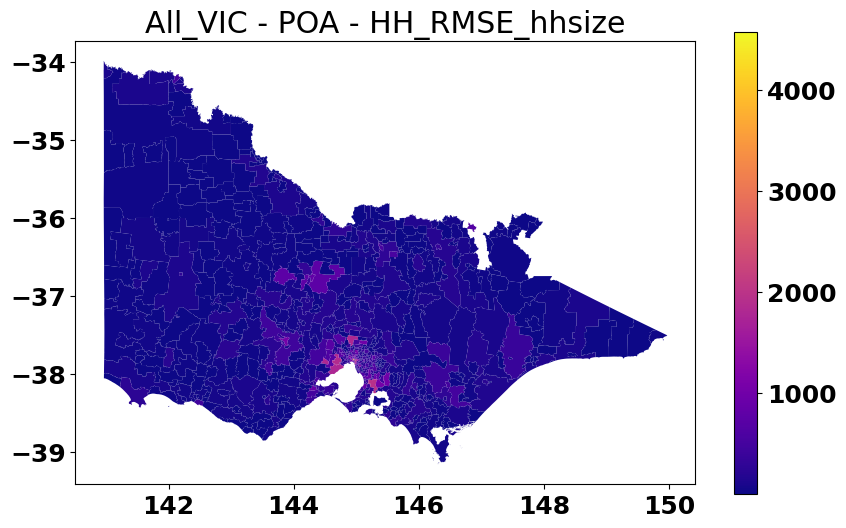

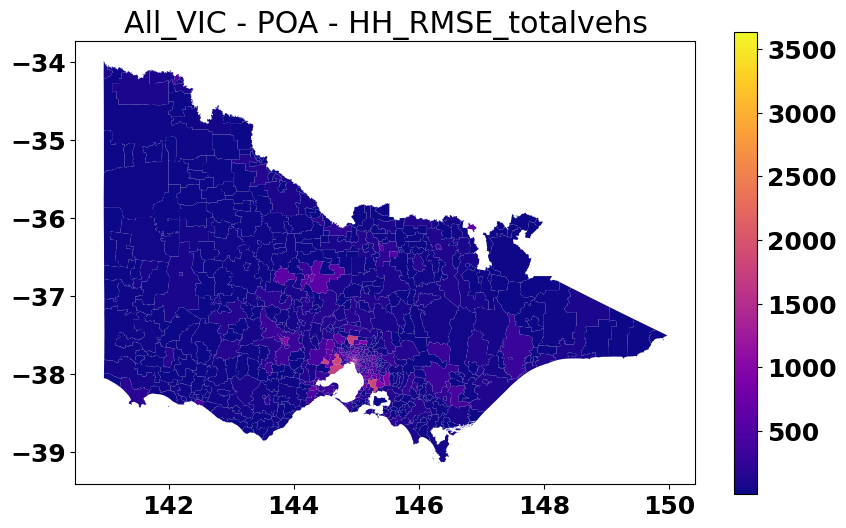

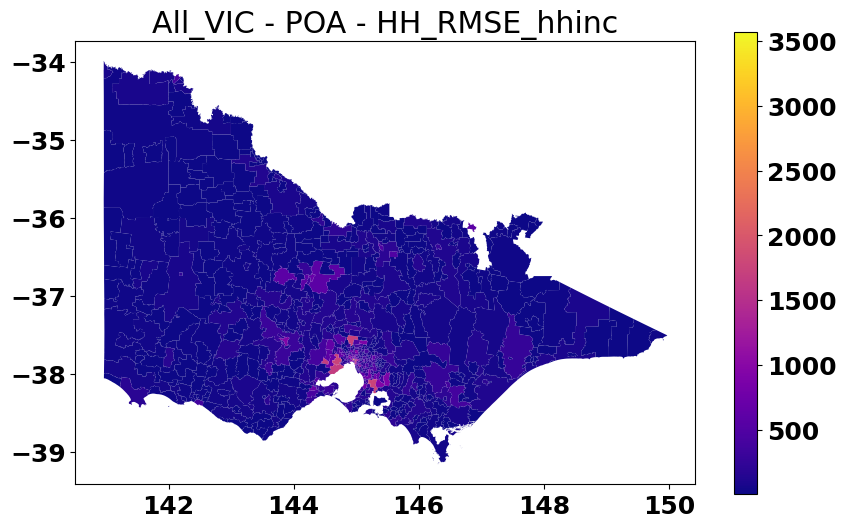

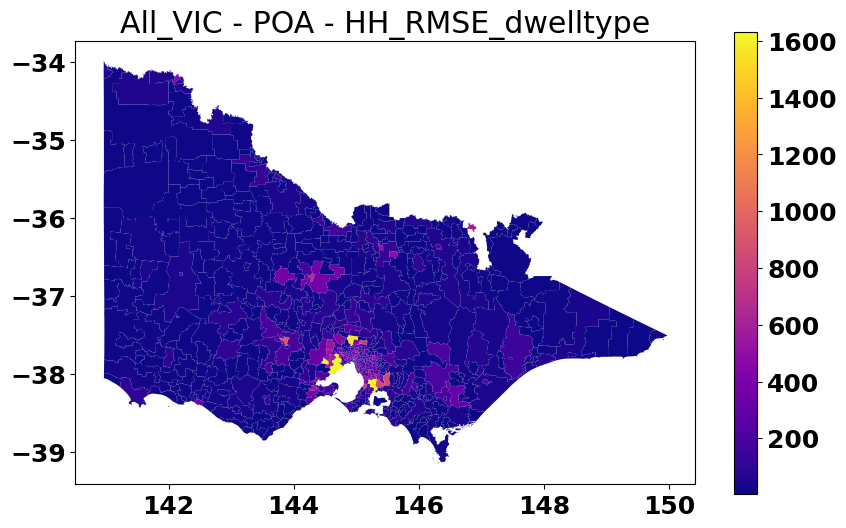

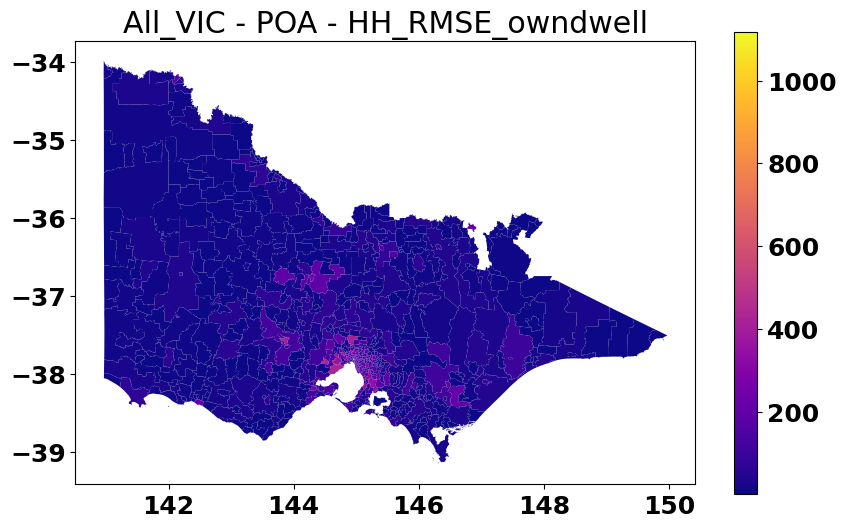

In [11]:
ls_syn_pop_hh = tuple(zip(ls_hh_ordered, ["None"]+ls_atts))
hh_zones_gdf, hh_sub_zones, hh_rmse, hh_atts_df, hh_states_df = wrapper_produce_all_results(ls_syn_pop_hh, marg_hh, "POA", poa_geo, to_plot=True, all_name="HH")

In [12]:
hh_atts_df.loc["avg"] = hh_atts_df.mean()
hh_atts_df = hh_atts_df.add_suffix("_adjusted")
hh_atts_df

None_adjusted  hhsize_adjusted  totalvehs_adjusted  hhinc_adjusted  \
hhsize        136.843834         0.000512            0.000512        0.000512   
dwelltype     457.740522       436.000756          390.468823      390.782646   
hhinc          95.536986        90.876502           90.848252       52.610523   
totalvehs     208.464836       152.680689           61.179368       61.179368   
owndwell      351.256591       323.332357          310.153913      310.918641   
avg           249.968554       200.578163          170.530173      163.098338   

           dwelltype_adjusted  owndwell_adjusted  
hhsize               0.000512           0.000512  
dwelltype           65.887334          65.887334  
hhinc               52.610523          52.610523  
totalvehs           61.179368          61.179368  
owndwell           283.943349          38.177463  
avg                 92.724217          43.571040

In [13]:
hh_atts_df_new = hh_atts_df.T.round(2)
hh_atts_df_new["adjustments"] = hh_atts_df_new.index
hh_atts_df_new

hhsize  dwelltype  hhinc  totalvehs  owndwell     avg  \
None_adjusted       136.84     457.74  95.54     208.46    351.26  249.97   
hhsize_adjusted       0.00     436.00  90.88     152.68    323.33  200.58   
totalvehs_adjusted    0.00     390.47  90.85      61.18    310.15  170.53   
hhinc_adjusted        0.00     390.78  52.61      61.18    310.92  163.10   
dwelltype_adjusted    0.00      65.89  52.61      61.18    283.94   92.72   
owndwell_adjusted     0.00      65.89  52.61      61.18     38.18   43.57   

                           adjustments  
None_adjusted            None_adjusted  
hhsize_adjusted        hhsize_adjusted  
totalvehs_adjusted  totalvehs_adjusted  
hhinc_adjusted          hhinc_adjusted  
dwelltype_adjusted  dwelltype_adjusted  
owndwell_adjusted    owndwell_adjusted

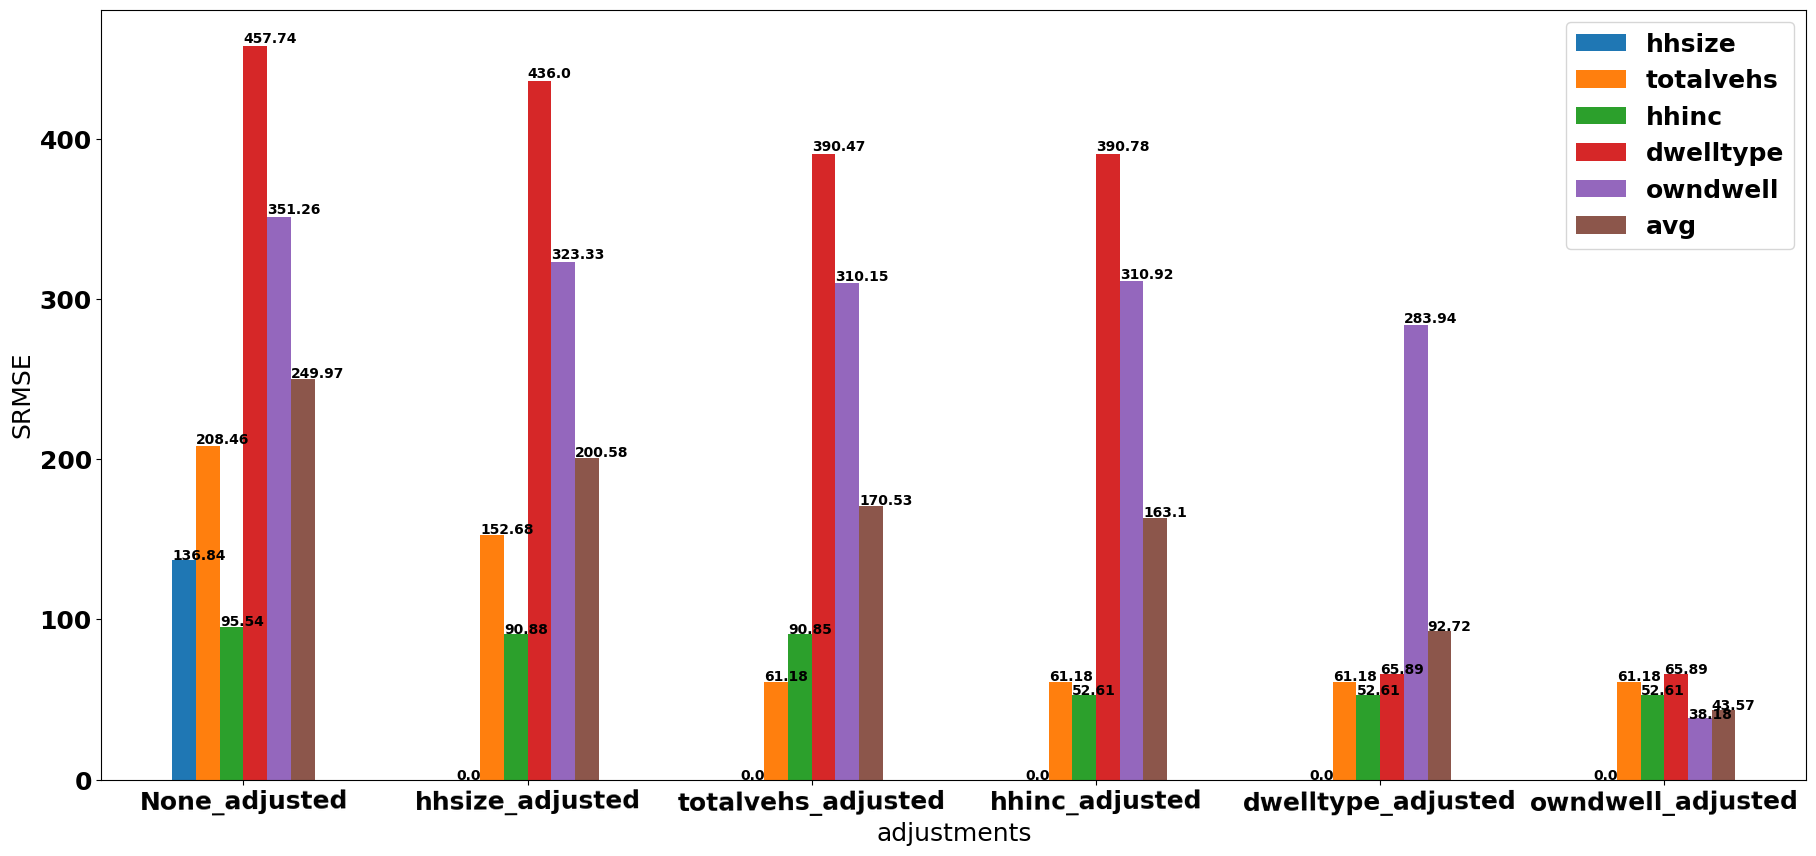

In [14]:
# fig, ax = plt.subplots()
ax = hh_atts_df_new.plot(x="adjustments", y=ls_atts+["avg"], kind='bar', figsize=(22,10), rot=0.444, ylabel="SRMSE")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.000, p.get_height() * 1.005), fontsize=10, rotation=0)
# ax.set_xticklabels(ax.get_xticks(), rotation = 30)